# Matrix Factorization (행렬분해)

In [186]:
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
import datetime as dt
import math as mt
import IPython
import IPython.display
from sklearn.decomposition import TruncatedSVD 
from scipy.spatial import distance
import scipy.stats

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='AppleGothic')  # MacOS
# matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 1~6, 9~12
low_pressure_fee = [
    [0,200,910,88.3],
    [201,400,1600, 182.9],
    [401,float('inf'),7300, 275.6]
]
# 7~8
low_pressure_fee_summer = [
    [0,300,910,88.3],
    [301,450,1600,182.9],
    [451,float('inf'),7300,275.6]
]
# 1~6, 9~12
high_pressure_fee = [
    [0,200,730,73.3],
    [201,400,1260,142.3],
    [400,float('inf'),6060,210.6]
]
# 7~8
high_pressure_fee_summer = [
    [0,300,730,73.3],
    [301,450,1260,142.3],
    [451,float('inf'),6060,210.6]
]

general_fee = {
    "저압": [6160, 100.7, 60.2, 87.3],
    "고압 A": [
        [7170, 110.9, 66.9, 98.6],
        [8230, 106.9, 62.6, 93.3]
    ],
    "고압 B": [
        [7170, 108.8, 65.8, 95.6],
        [8230, 103.5, 60.5, 90.3]
    ]
}
env_fee = 5.3
fuel_fee = 3
VAT = 0.1
FUND = 0.037

class Household:
    def __init__(self,
                name, kwh, contract, contract_name):
        self.name = name
        self.kwh = kwh
        self.contract = contract
        self.contract_name = contract_name
        
    def set_bill(self,
                public_fee):
        self.self_fee = self.elec_bill_vat_fund
        self.public_fee = public_fee
        self.bill = self.self_fee + self.public_fee
        
    @property
    def basic(self):
        fee = None
        for _ in self.contract:
            if _[0] <= self.kwh and _[1] >= self.kwh:
                fee = _[2]
                break
        return fee
    
    @property
    def elec_rate(self):
        kwh = self.kwh
        fee = 0
        for _ in self.contract:
            if kwh <= _[1]:
                fee += (kwh * _[3])
                break
            else:
                kwh -= _[1]
                fee += (_[1] * _[3])
        
        return mt.floor(fee)
        
    @property
    def guarantee(self):
        if self.kwh <= 200:
            if self.contract_name == "종합계약":
                return 4000
            elif self.contract_name == "단일계약":
                return 2500
        else:
            return 0
        
    @property
    def elec_bill(self):
        bill = self.basic + self.elec_rate\
            - self.guarantee + self.env - self.fuel
        
        if bill < 1000:
            return 1000
        else:
            return bill
    
class Public:
    def __init__(self,
                kwh,
                charge_applied,
                contract):
        # 공용설비사용량
        self.kwh = kwh
        # 요금적용전력
        self.charge_applied = charge_applied
        self.contract = contract
        
    @property
    def basic(self):
        return mt.floor(self.charge_applied * self.contract[0])
    
    @property
    def elec_rate(self):
        return mt.floor(self.kwh * self.contract[1])
    
    @property
    def elec_bill(self):
        bill = self.basic + self.elec_rate + self.env - self.fuel
        
        if bill < 1000:
            return 1000
        else:
            return bill
    
@property
def env(self):
    return mt.floor(self.kwh * env_fee)
@property
def fuel(self):
    return mt.floor(self.kwh * fuel_fee)
@property
def vat(self):
    return round(self.elec_bill * 0.1)
@property
def fund(self):
    return mt.floor(self.elec_bill * 0.037 * 0.1) * 10
@property
def elec_bill_vat_fund(self):
    return mt.floor((self.elec_bill + self.vat + self.fund) * 0.1) * 10

Household.env = env
Household.fuel = fuel
Household.vat = vat
Household.fund = fund
Household.elec_bill_vat_fund = elec_bill_vat_fund

Public.env = env
Public.fuel = fuel
Public.vat = vat
Public.fund = fund
Public.elec_bill_vat_fund = elec_bill_vat_fund
    
class ManagementOffice:
    def __init__(self, 
                 month, peaks, households, APT, # datas
                 contract,
                 general_fee_info=None):
        print("[관리사무소] Init.")
        
        self.peaks = peaks
        self.APT = APT
        
        self.contract = contract
        self.select_fee(month, contract, general_fee_info)
        
        if contract == "종합계약":
            # 가구 객체화
            # - 가구별 지정된 계약에 요금들이 계산되도록 Property 구성해놨음.
            print("[관리사무소] 가구 객체화")
            self.households = list()
            for idx in households.index:
                self.households.append(
                    Household(
                        name=households.iloc[idx]['name'],
                        kwh=households.iloc[idx]['usage (kWh)'],
                        contract=self.fee[0],
                        contract_name=contract
                    )
                )

            # 공용설비사용요금
            print("[관리사무소] 공용설비사용요금 계산")
            households_kwh = sum([_.kwh for _ in self.households])
            public_kwh = APT - households_kwh
            max_peak = peak_df['peak (kW)'].max()
            charge_applied = max_peak * (public_kwh / APT)
            
            self.public = Public(
                kwh=public_kwh,
                charge_applied=charge_applied,
                contract=self.fee[1]
            )

            # 가구별 청구서 셋팅
            public_fee = round(self.public.elec_bill_vat_fund / len(self.households) / 10) * 10
            
            print("public fee", public_fee)
            for household in self.households:
                household.set_bill(
                    public_fee=public_fee
                )

            # 아파트 청구서 셋팅
            bill = 0
            for household in self.households:
                bill += household.bill
            self.bill = bill
        elif contract == "단일계약":
            # 전체를 하나의 가구 본 상태에서 계약대로 계산식 진행
            # 후에 * len(household) 를 통해 아파트 전체 요금 통지서 확보
            num_household = len(households)
            mean_kwh = APT / num_household

            apart = Household(
                name="아파트",
                kwh=mean_kwh,
                contract=self.fee,
                contract_name=contract
            )
            basic = apart.basic * num_household
            elec_rate = apart.elec_rate * num_household
            env = apart.env * num_household
            fuel = apart.fuel * num_household
            
            elec_bill = basic + elec_rate + env - fuel
            self.bill = mt.floor((elec_bill \
                + round(elec_bill * 0.1) \
                + mt.floor(elec_bill * 0.037 * 0.1) * 10) * 0.1) * 10
            
            # 가구 객체화
            # - 가구별 지정된 계약에 요금들이 계산되도록 Property 구성해놨음.
            print("[관리사무소] 가구 객체화")
            self.households = list()
            for idx in households.index:
                self.households.append(
                    Household(
                        name=households.iloc[idx]['name'],
                        kwh=households.iloc[idx]['usage (kWh)'],
                        contract=self.fee,
                        contract_name=contract
                    )
                )
                
            # 공공설비사용요금
            households_bill = sum(
                [_.elec_bill_vat_fund for _ in self.households]
            )
            print("가구 청구 비용 : {}".format(format(households_bill)))
            self.public_bill = self.bill - households_bill
            
            
            # 가구별 청구서 셋팅
            public_fee = round(self.public_bill / len(self.households))
            for household in self.households:
                household.set_bill(
                    public_fee=public_fee
                )

    # 요금제 셋팅 메서드
    def select_fee(self, month, contract, general_fee_info):
            print("[관리사무소] 계약 정보 셋팅")

            if contract == "종합계약":
                household_fee = None
                public_fee = None
                if (month >= 1 and month <= 6) or\
                    (month >= 9 and month <= 12):
                    household_fee = low_pressure_fee
                else:
                    household_fee = low_pressure_fee_summer

                if general_fee_info == None:
                    raise Exception("종합계약은 일반용 전력 정보를 포함해야 합니다.\n")

                tmp_general_fee = None
                if general_fee_info == "저압":
                    tmp_general_fee = general_fee[general_fee_info]
                elif len(general_fee_info) == 2:
                    tmp_general_fee = general_fee[general_fee_info[0]]
                    tmp_general_fee = tmp_general_fee[general_fee_info[1]]
                else: 
                    raise Exception("일반용 전력 설정이 올바르지 않습니다\n"\
                                + "저압, [고압 A, 0 or 1], [고압 B, 0 or 1]")

                if month >= 6 and month <= 8:
                    public_fee = [tmp_general_fee[0], tmp_general_fee[1]]
                elif (month >= 3 and month <= 5) or\
                      (month >= 9 and month <= 10):
                    public_fee = [tmp_general_fee[0], tmp_general_fee[2]]
                elif (month >= 1 and month <= 2) or\
                      (month >= 11 and month <= 12):
                    public_fee = [tmp_general_fee[0], tmp_general_fee[3]]
                self.fee = [household_fee, public_fee]
                
            elif contract == "단일계약":
                if (month >= 1 and month <= 6) or\
                    (month >= 9 and month <= 12):
                    self.fee = high_pressure_fee
                else:
                    self.fee = high_pressure_fee_summer

            print("[관리사무소] 계약 정보 셋팅 완료\n")
            print(self.fee)        
            print("")

In [3]:
xlsx = pd.read_excel("datas/datas.xlsx", header=None, skiprows=2, engine="openpyxl")

In [198]:
date_df = xlsx[3:][xlsx.columns[1:6]].copy()
household_df = xlsx[xlsx.columns[7:]]

date_list = [dt.datetime(
    date_df.loc[_][1],
    date_df.loc[_][2],
    date_df.loc[_][3],
    date_df.loc[_][4],
    date_df.loc[_][5]
) for _ in date_df.index]

datas_df = pd.DataFrame(columns=['date'])
datas_df['date'] = date_list

for col in household_df:
    household_name = "{}-{}-{}".format(
        household_df[col][0],
        household_df[col][1],
        household_df[col][2]
    )
    datas_df[household_name] = household_df[col][3:].to_list()
    
datas_df = datas_df.replace("-", 0)

sum_df = pd.DataFrame(columns=['date', 'kWh', 'kW'])
sum_df['date'] = date_list
sum_df['kWh'] = [round (_) for _ in datas_df[datas_df.columns.difference(['date'])].sum(axis=1).to_list()]
sum_df['kW'] = (sum_df['kWh'] / 0.25).to_list()

peak_df = pd.DataFrame(columns=['month', 'peak (kW)'])
for month in range(1,13):
    peak_df = peak_df.append({
        "month": str(month),
        "peak (kW)": sum_df[sum_df['date'].dt.month == month]['kW'].max()
    }, ignore_index=True)

month_usage_df = pd.DataFrame(columns=['month'])
month_usage_df['month'] = [_ for _ in range(1,13)]

for name in datas_df[datas_df.columns.difference(['date'])]:
    self_household_df = datas_df[['date',name]].copy()
    
    month_usage_df[name] = [
        round(self_household_df[self_household_df['date'].dt.month == month][name].sum())
        for month in range(1,13)
    ]  

analysis_df = month_usage_df.set_index("month")
better_comp_df = pd.DataFrame()

for month in range(1, 13):
    # 1. 월별 사용량 데이터 파싱
    month_datas_df = pd.DataFrame(columns=["name","usage (kWh)"])
    for idx in analysis_df.loc[month].index:
        household_name = idx
        household_kWh = analysis_df.loc[month][idx]

        month_datas_df = month_datas_df.append({
            "name": household_name,
            "usage (kWh)": household_kWh
        }, ignore_index=True)

    # Thinking
    # 세대부 전기는 정해져 있는데,
    # 공용부 전기는 정해져 있지가 않아서 입력되는 percentage에 따라, 변화하도록

    # 다음과 같은 공식을 사용할 수 있다.
    # n -> 공용부가 전체 APT에서 차지할 percentage
    # APT : households_kWh = 100 : (100 - n)
    # APT : public_kWh = 100 : n

    # 이에 따라,
    # APT = (households_kWh * 100) / (100 - n)
    # public_kwh = APT - households_kwh
    min_per = 10
    max_per = 80
    rows = np.array([])

    for PUBLIC_PERCENTAGE in range(min_per, max_per + 1):
        households_kWh = sum(month_datas_df['usage (kWh)'].values)
        APT = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))
        public_kWh = round(APT - households_kWh)

        # 종합계약
        calc = ManagementOffice(
            month=month,
            peaks=peak_df, 
            households=month_datas_df,
            APT=APT,
            contract="종합계약",
            general_fee_info=['고압 A', 1]
        )

        # 단일계약
        single_calc = ManagementOffice(
            month=month,
            peaks=peak_df, 
            households=month_datas_df,
            APT=APT,
            contract="단일계약"
        )

        cnt = len(calc.households)
        comp_cnt = 0
        draw_cnt = 0
        single_cnt = 0
        for idx in range(0, cnt):
            if calc.households[idx].bill > single_calc.households[idx].bill:
                single_cnt += 1
            elif calc.households[idx].bill < single_calc.households[idx].bill:
                comp_cnt += 1
            else:
                draw_cnt

        rows = np.append(rows,comp_cnt)

        IPython.display.clear_output()

    better_comp_df = better_comp_df.append(
        pd.Series(rows, index=["{}".format(_) for _ in range(min_per, max_per + 1)], name=month))
    better_comp_df
    
better_comp_df

,10,11,12,13,14,15,16,17,18,19,...,71,72,73,74,75,76,77,78,79,80
1,11.0,13.0,15.0,18.0,18.0,19.0,22.0,24.0,35.0,44.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
2,13.0,16.0,18.0,20.0,21.0,28.0,37.0,41.0,52.0,60.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
3,52.0,70.0,82.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
4,65.0,76.0,93.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
6,4.0,5.0,5.0,6.0,8.0,8.0,9.0,12.0,18.0,19.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
9,62.0,81.0,95.0,114.0,137.0,137.0,137.0,137.0,137.0,137.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
10,57.0,73.0,88.0,103.0,115.0,115.0,115.0,115.0,115.0,115.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0


In [199]:
idx_exclude_summer = better_comp_df.index.difference([7,8])

# mean_sr = np.floor(pd.Series(better_comp_df.mean(), name="mean"))
# mean_exclude_sum_sr = pd.Series(better_comp_df.loc[idx_exclude_summer].mean(), name="mean exclude summer")
# mean_sum_sr = pd.Series(better_comp_df.loc[[7,8]].mean(), name="mean summer")

analysis_df = better_comp_df.append([
#     mean_sr,
#     mean_exclude_sum_sr,
#     mean_sum_sr
])

feature shape (12, 12)


<AxesSubplot:>

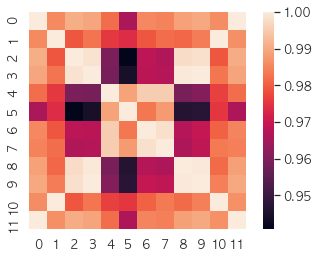

In [200]:
SVD = TruncatedSVD(n_components=36)
matrix = SVD.fit_transform(analysis_df)
print("feature shape", matrix.shape)

corr = np.corrcoef(matrix)
sns.heatmap(corr, #데이터
            cbar=True, #오른쪽 컬러 막대 출력 여부
            square=True, #차트를 정사각형으로 할 것인지
           )

In [201]:
matrix.shape

(12, 12)

In [202]:
months = analysis_df.index
max_corr = corr.sum(axis=1).argmax()
min_corr = corr.sum(axis=1).argmin()

In [203]:
best_sim_idx = months[max_corr]
worst_sim_idx = months[min_corr]

In [204]:
mean_sr = np.floor(pd.Series(better_comp_df.mean(), name="mean"))

analysis_df = analysis_df.append([
    mean_sr
])

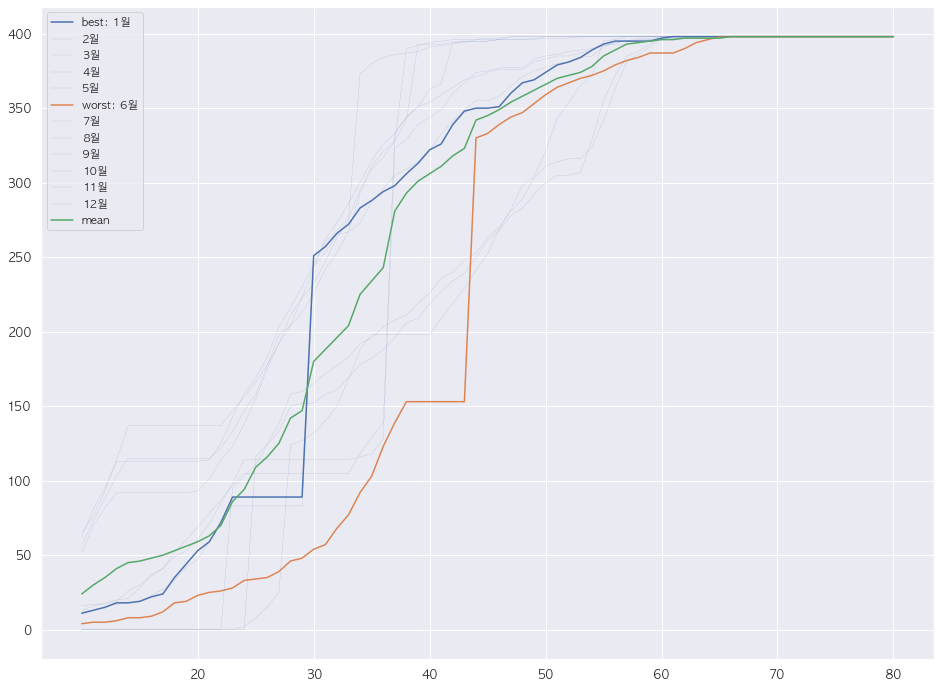

In [207]:
plt.figure(figsize=(16,12))
plt.xticks(range(min_per, max_per, 10))

for idx in analysis_df.index:
    label = "general"
    
    if idx == best_sim_idx:
        label = "best: {}월".format(idx)
    elif idx == worst_sim_idx:
        label = "worst: {}월".format(idx)
    elif idx == "mean":
        label = "mean"
    elif idx == "mean exclude summer":
        label = "mean exclude summer"
    elif idx == "mean summer":
        label = "mean summer"
    
    if label == "general":
        plt.plot(analysis_df.loc[idx], label="{}월".format(idx), linewidth=0.1, color="b")
    else:
        plt.plot(analysis_df.loc[idx], label=label, linewidth=1.5)
        
plt.legend()
plt.show()

In [175]:
len_chk_df = month_usage_df.set_index('month')
length = len(len_chk_df.columns)

## 상관계수 vs mean

In [156]:
idx_exclude_best = better_comp_df.index.difference([best_sim_idx, worst_sim_idx])
compare_df = better_comp_df.loc[idx_exclude_best]

compare_df

,10%,11%,12%,13%,14%,15%,16%,17%,18%,19%,...,71%,72%,73%,74%,75%,76%,77%,78%,79%,80%
2,13.0,16.0,18.0,20.0,21.0,28.0,37.0,41.0,52.0,60.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
3,52.0,70.0,82.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
4,65.0,76.0,93.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
9,62.0,81.0,95.0,114.0,137.0,137.0,137.0,137.0,137.0,137.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
10,57.0,73.0,88.0,103.0,115.0,115.0,115.0,115.0,115.0,115.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
11,16.0,17.0,17.0,19.0,26.0,30.0,36.0,41.0,49.0,53.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0
12,12.0,13.0,15.0,17.0,18.0,19.0,23.0,27.0,33.0,42.0,...,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0,398.0


In [157]:
best_sim_sr = better_comp_df.loc[best_sim_idx]
worst_sim_sr = better_comp_df.loc[worst_sim_idx]
mean_sim_sr = np.floor(pd.Series(better_comp_df.mean(), name="mean"))

In [158]:
compare_arr = np.array(compare_df)
best_sim_arr = np.array(best_sim_sr)
worst_sim_arr = np.array(worst_sim_sr)
mean_sim_arr = np.array(mean_sim_sr)

print(compare_arr.shape, 
      best_sim_arr.shape, 
      worst_sim_arr.shape,
      mean_sim_arr.shape)

(10, 71) (71,) (71,) (71,)


In [159]:
# similarity functions
# 유클리디안 거리
# 코사인 유사도
def cos(A, B):
    return dot(A, B)/(norm(A)*norm(B))

def euc(A, B):
    return distance.euclidean(A, B)

def sumDiffer(A, B):
    err_sum = 0
    for idx, _ in enumerate(A):
        err = (_ - B[idx]) ** 2
        err_sum += err
    
    err_mean = err_sum / len(A)
    return np.sqrt(err_mean)

def cos_sum(A, B, weight):
    cosine = cos(A, B)
    sd = sumDiffer(A, B)
    
    return cosine * (weight ** sd)

In [160]:
best_compare_df = pd.DataFrame(index=["거리", "방향", "거리 + 방향"])
for idx, B in enumerate(compare_arr):
    A = best_sim_arr
    dis = euc(A, B)
    cosine_similarity = cos(A, B)
    dis_cos = cos_sum(A, B, 0.9)
    
    best_compare_df[
        compare_df.index[idx]
    ] = [
        dis,
        cosine_similarity,
        dis_cos
    ]

mean_compare_df = pd.DataFrame(index=["거리", "방향", "거리 + 방향"])
for idx, B in enumerate(compare_arr):
    A = np.array(mean_sim_sr)
    dis = euc(A, B)
    cosine_similarity = cos(A, B)
    dis_cos = cos_sum(A, B, 0.9)
    
    mean_compare_df[
        compare_df.index[idx]
    ] = [
        dis,
        cosine_similarity,
        dis_cos
    ]
    
worst_compare_df = pd.DataFrame(index=["거리", "방향", "거리 + 방향"])
for idx, B in enumerate(compare_arr):
    A = np.array(worst_sim_sr)
    dis = euc(A, B)
    cosine_similarity = cos(A, B)
    dis_cos = cos_sum(A, B, 0.9)
    
    worst_compare_df[
        compare_df.index[idx]
    ] = [
        dis,
        cosine_similarity,
        dis_cos
    ]

In [161]:
best_compare_df

,2,3,4,5,7,8,9,10,11,12
거리,433.615037,418.167431,436.656616,520.850266,480.897078,500.958082,449.853309,411.111907,428.012850,28.844410
방향,0.986329,0.990542,0.989073,0.982989,0.986455,0.985361,0.987976,0.990035,0.986680,0.999940
거리 + 방향,0.004358,0.005309,0.004207,0.001459,0.002413,0.001876,0.003563,0.005796,0.004676,0.697167


In [162]:
mean_compare_df

,2,3,4,5,7,8,9,10,11,12
거리,303.234233,439.844291,422.203742,446.486282,386.389700,394.603599,430.665764,387.891737,290.623468,212.760429
방향,0.993190,0.990809,0.991342,0.986422,0.990716,0.990578,0.990448,0.992608,0.993736,0.996933
거리 + 방향,0.022405,0.004050,0.005052,0.003711,0.007901,0.007129,0.004541,0.007769,0.026246,0.069709


In [163]:
worst_compare_df

,2,3,4,5,7,8,9,10,11,12
거리,593.243626,1003.752958,981.616524,353.093472,457.471311,436.624553,971.298100,943.696455,580.147395,695.762891
방향,0.975765,0.939514,0.941560,0.989047,0.981493,0.983029,0.942115,0.945404,0.976914,0.966734
거리 + 방향,0.000586,0.000003,0.000004,0.011961,0.003218,0.004183,0.000005,0.000007,0.000691,0.000161


In [180]:
mean_comp_point = 80

for idx,_ in enumerate(mean_sim_arr):
    if _ > (length / 2):
        mean_comp_point = idx
        break

best_comp_point = 80
for idx,_ in enumerate(best_sim_arr):
    if _ > (length / 2):
        best_comp_point = idx
        break
        
worst_comp_point = 80
for idx,_ in enumerate(worst_sim_arr):
    if _ > (length / 2):
        worst_comp_point = idx
        break
        
print(mean_comp_point, best_comp_point, worst_comp_point)

23 20 34
